<a href="https://colab.research.google.com/github/JohnVicke/deep-learning/blob/main/viktor_malmedal_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer learning

```
Author: Viktor Malmedal
Mail:   viktormalmedal@gmail.com
umuId:  vima0068
```
Use a trained model to reach over 91.5% test accuracy on MNIST-Fashion data set



In [ ]:
import tensorflow as tf
import tensorflow.keras
import numpy as np
from sklearn.model_selection import train_test_split

import matplotlib
import matplotlib.pyplot as plt
print(f'Keras version      = {tensorflow.keras.__version__}')
print(f'Tensorflow version = {tf.__version__}')

Keras version      = 2.7.0
Tensorflow version = 2.7.0


In [ ]:
import sys
if not tf.config.list_physical_devices('GPU'):
    print('No GPU detected. CNNs can be very slow without a GPU')
    if 'google.colab' in sys.modules:
        print('Go to RunTime > change runtime and select a GPU hardware accelerator')
else:
    !nvidia-smi -L

GPU 0: Tesla K80 (UUID: GPU-312c6c20-688b-dabb-0400-0f62f8dd0c9b)


In [ ]:
def normalize_data(data):
    return data.astype('float32') / 255.0

In [ ]:
def resize_data(data, dim=[32,32]):
    return np.asarray(tf.image.resize(data, dim, method='nearest'))

In [ ]:
from keras.preprocessing.image import img_to_array, array_to_img
def reshape_data(data):
    data = np.expand_dims(data, axis=-1)
    data = np.repeat(data, 3, axis=-1)
    return data

In [ ]:
from tensorflow.keras.datasets import fashion_mnist
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
_, img_width, img_height = x_train.shape
print('----- Data -----')
print(f'Train: images{x_train.shape} | labels {y_train.shape}')
print(f'Test:  images{x_test.shape} | labels {y_test.shape}')
print()

# Keep original values for analysis
train_x = resize_data(reshape_data(normalize_data(x_train)))
test_x  = resize_data(reshape_data(normalize_data(x_test)))

print('----- Reshaped data ------')
print(f'Train: images{train_x.shape}')
print(f'Test:  images{test_x.shape}')


4431872/4422102 [==============================] - 0s 0us/step
----- Data -----
Train: images(60000, 28, 28) | labels (60000,)
Test:  images(10000, 28, 28) | labels (10000,)

----- Reshaped data ------
Train: images(60000, 32, 32, 3)
Test:  images(10000, 32, 32, 3)


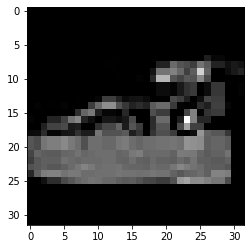

In [ ]:
# Arbitrary image to see if resize succeeded
plt.imshow(train_x[1337], cmap=plt.get_cmap('gray'))
plt.show()

In [ ]:
from tensorflow.keras.utils import to_categorical
RANDOM_STATE = 12
test_y = to_categorical(y_test)
train_x, val_x, train_y, val_y = train_test_split(train_x,
                                                  to_categorical(y_train),
                                                  test_size=0.2,
                                                  random_state=RANDOM_STATE)


In [ ]:
train_x.shape, val_x.shape, test_x.shape, train_y.shape, val_y.shape, test_y.shape

((48000, 32, 32, 3),
 (12000, 32, 32, 3),
 (10000, 32, 32, 3),
 (48000, 10),
 (12000, 10),
 (10000, 10))

In [ ]:
DIM = [32,32]
INPUT_SHAPE = (*DIM, 3)

# Explore the VGG16 model
Here we have the very deep VGG16 convolutional network developed by the *Visual Geometry Group*. It consits of 19 total layer and has performed a top-5 test accuracy in ImageNet, which are the weights that are going to be used in this laboration. VGG16 was allegedly trained for weeks using NVIDA Titan Black GPUs.

Image dimension are going to play a big role in how many layers from VGG16 that can be included because of the subsampling from the maxpooling layers. To include all 4 blocks, the image dimenions has to be atleast 70x70px for pooling layers = (16, 8, 4, 2 ,1)

In [ ]:
from tensorflow.keras.applications import VGG16

vgg = VGG16(
    weights='imagenet',
    include_top=False, # Doesn't match current input_shape
    input_shape=INPUT_SHAPE
)
vgg.summary()


58900480/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                              

In [ ]:
def get_output_tensor(name, layers):
    # Will throw error for layers that do not exist
    output = None
    included_layers = 0
    for i, layer in enumerate(layers):
        if layer.name == name:
            output = layer.output
            included_layers = i
            break

        
    return output, included_layers


# Extended model
To extend the model I am linking the input and output of VGG16 together with the newly created layers. 
- VGG as input and the new layers as output

In [ ]:
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D 
from keras.layers import Flatten, Dense, Dropout, BatchNormalization

def get_extended_model(output_tensor, input_tensor):
    x = output_tensor

    x = Conv2D(64, kernel_size=(5,5), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
    x = Dropout(0.25)(x)

    x = Conv2D(128, kernel_size=(5,5), padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
    x = Dropout(0.25)(x)
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.25)(x)
    x = Dense(10, activation='softmax')(x)
    return Model(input_tensor, x)

In [ ]:
output_tensor, included_layers = get_output_tensor('block3_pool', vgg.layers)
input_tensor = vgg.input
extended_model = get_extended_model(output_tensor, input_tensor)
extended_model.summary()



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

# Turning off trainable for included layers
The included layers should not be re-trained in order to take full advantage of transfer learning. Trainable params go from around ~2.5mil to ~650k.

In [ ]:
for layer in extended_model.layers[:included_layers]:
    layer.trainable = False

extended_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
EPOCHS = 20 
BATCH_SIZE = 32
optimizer = Adam(learning_rate=0.0001)
early_stop_monitor = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True, verbose=1)
reduce_lr_monitor = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0, verbose=1, min_delta=0.0001)

In [ ]:
extended_model.compile(loss='categorical_crossentropy',
                       optimizer=optimizer,
                       metrics=['categorical_accuracy'])

In [ ]:
import time
print(f'Starting to train model....')
global_start_time = time.time()

history = extended_model.fit(train_x, train_y,
                             shuffle=True,
                             epochs=EPOCHS, batch_size=BATCH_SIZE,
                             verbose=2, validation_data=(val_x, val_y), 
                             callbacks=[early_stop_monitor, reduce_lr_monitor])

stopped_at = early_stop_monitor.stopped_epoch
if stopped_at == 0:
    stopped_at = EPOCHS - 1

global_elapsed_time = time.time() - global_start_time
print(f'Finisihed training all model in {hms_string(global_elapsed_time)}')

Epoch 1/20
1500/1500 - 32s - loss: 0.5198 - categorical_accuracy: 0.8221 - val_loss: 0.2823 - val_categorical_accuracy: 0.9001 - lr: 1.0000e-04 - 32s/epoch - 21ms/step
Epoch 2/20
1500/1500 - 22s - loss: 0.3353 - categorical_accuracy: 0.8817 - val_loss: 0.2665 - val_categorical_accuracy: 0.9031 - lr: 1.0000e-04 - 22s/epoch - 15ms/step
Epoch 3/20
1500/1500 - 22s - loss: 0.3012 - categorical_accuracy: 0.8934 - val_loss: 0.2417 - val_categorical_accuracy: 0.9138 - lr: 1.0000e-04 - 22s/epoch - 15ms/step
Epoch 4/20
1500/1500 - 20s - loss: 0.2732 - categorical_accuracy: 0.9022 - val_loss: 0.2350 - val_categorical_accuracy: 0.9160 - lr: 1.0000e-04 - 20s/epoch - 13ms/step
Epoch 5/20
1500/1500 - 22s - loss: 0.2601 - categorical_accuracy: 0.9070 - val_loss: 0.2252 - val_categorical_accuracy: 0.9198 - lr: 1.0000e-04 - 22s/epoch - 15ms/step
Epoch 6/20
1500/1500 - 20s - loss: 0.2460 - categorical_accuracy: 0.9115 - val_loss: 0.2248 - val_categorical_accuracy: 0.9193 - lr: 1.0000e-04 - 20s/epoch - 13

In [ ]:
extended_model.evaluate(test_x, test_y)
print(stopped_at)

313/313 [==============================] - 4s 13ms/step - loss: 0.2083 - categorical_accuracy: 0.9285
19


In [ ]:
def retrieve(mapping, *keys):
    return (mapping[key] for key in keys)

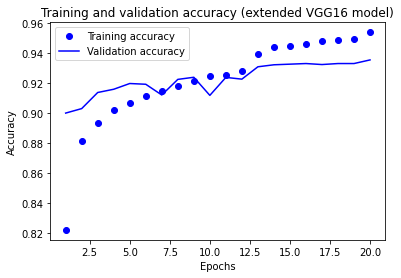

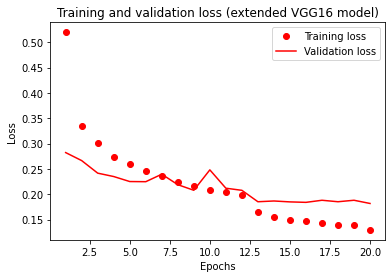

In [ ]:
 train_loss, train_acc, val_loss, val_acc = retrieve(history.history,
                                                     'loss',
                                                     'categorical_accuracy',
                                                     'val_loss',
                                                     'val_categorical_accuracy')

epoch_range = range(1, stopped_at + 2)
plt.plot(epoch_range, train_acc, 'bo', label='Training accuracy')
plt.plot(epoch_range, val_acc, 'b', label='Validation accuracy')
plt.title(f'Training and validation accuracy (extended VGG16 model)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(epoch_range, train_loss, 'bo', color='red', label='Training loss')
plt.plot(epoch_range, val_loss, 'b', color='red', label='Validation loss')
plt.title(f'Training and validation loss (extended VGG16 model)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Conclusion
I managed to get around ~93% testing accuracy with my proposed solution. I've experimented with a lot of different techniques, data augmentation, random sampling, different image scaling etc. In the graph we can see that the training accuracy suddenly increases around 12 epochs, which is where the reduced learning callback kicks in. It might increase the probability that the model will overfit, however it also provides a better test score (which is what this laboration uses as a measurment for success) so I kept it in. 

Using pretrained parameters (weights) as a base decreases the amount of trainable parameters which also greatly decreases the amount of time it takes to train the model. However, I personally think that this model is a bit of an overkill for the assignment. When we are looking at how my models in earlier laborations performed with relativley small networks (low nr of layers and complexity) comapred to this one, the small difference in performance is almost negliable, if there is any at all.

For other tasks, I think that this method could be super advantegous. Instead of building, testing and training such a complex model for weeks (months, years?) we can use something that someone much smarter has developed, add our own layers for our specific task and minimize a lot of time and effort required to produce superb results. 